<a href="https://colab.research.google.com/github/Shalini-Mirani/ADSLAB/blob/main/ADSEXP6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

#Import the required libraries

import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["NonDiabetic", "Diabetic"]
import plotly.graph_objs as go
import plotly
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, iplot

In [38]:
df = pd.read_csv('/content/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [39]:
# Preprocess data
X = df.drop('Outcome', axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [40]:
# Outlier Detection using Isolation Forest
isolation_forest = IsolationForest(contamination=0.1, random_state=42)
outlier_labels_isof = isolation_forest.fit_predict(X_scaled)

# Density-Based Anomaly Detection (DBSCAN)
dbscan = DBSCAN(eps=0.5, min_samples=5)
outlier_labels_dbscan = dbscan.fit_predict(X_scaled)

# Distance-Based Anomaly Detection (LOF)
lof = LocalOutlierFactor(n_neighbors=20)
outlier_scores_lof = lof.fit_predict(X_scaled)

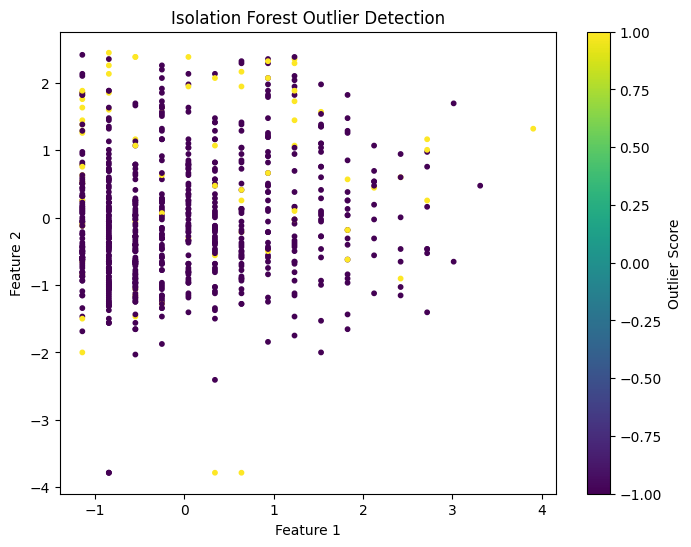

In [41]:
# Visualize results
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=-outlier_labels_isof, cmap='viridis', s=10)
plt.title('Isolation Forest Outlier Detection')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Outlier Score')
plt.show()

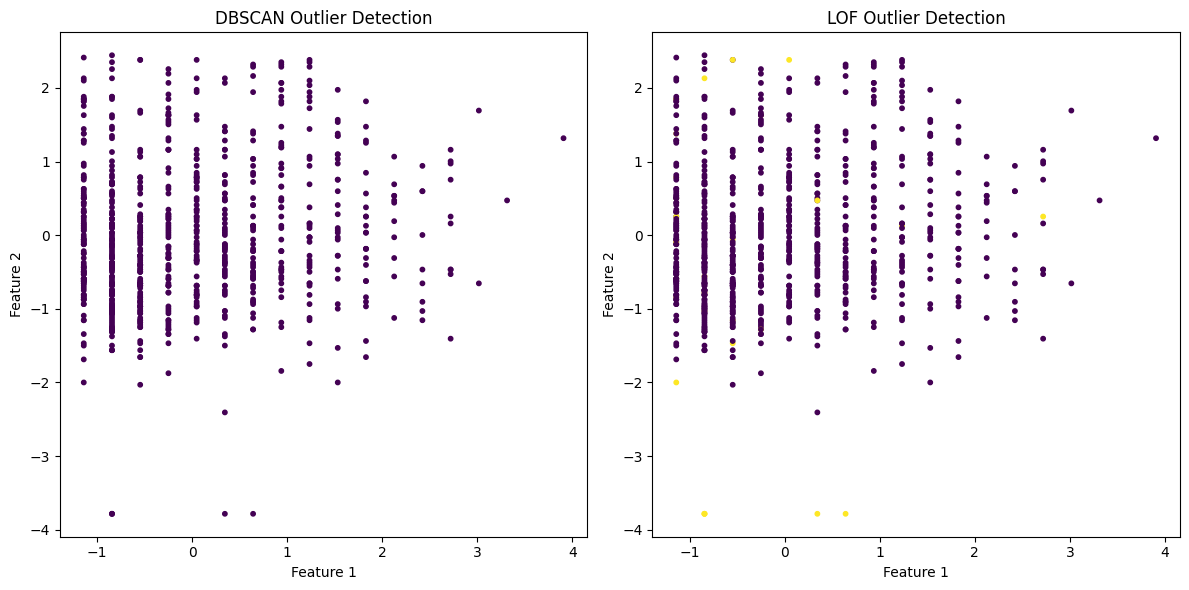

In [42]:
# Visualize results
plt.figure(figsize=(12, 6))

# DBSCAN
plt.subplot(1, 2, 1)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=outlier_labels_dbscan, cmap='viridis', s=10)
plt.title('DBSCAN Outlier Detection')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
# LOF
plt.subplot(1, 2, 2)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=-outlier_scores_lof, cmap='viridis', s=10)
plt.title('LOF Outlier Detection')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()

In [43]:


Diabetic = df[df['Outcome']==1]
NonDiabetic = df[df['Outcome']==0]
outlier_fraction = len(Diabetic)/float(len(NonDiabetic))

In [44]:
#Now let us print the outlier fraction and no of Fraud and Valid Transaction cases

print(outlier_fraction)
print("Diabetic Cases : {}".format(len(Diabetic)))
print("NonDiabetic Cases : {}".format(len(NonDiabetic)))

0.536
Diabetic Cases : 268
NonDiabetic Cases : 500


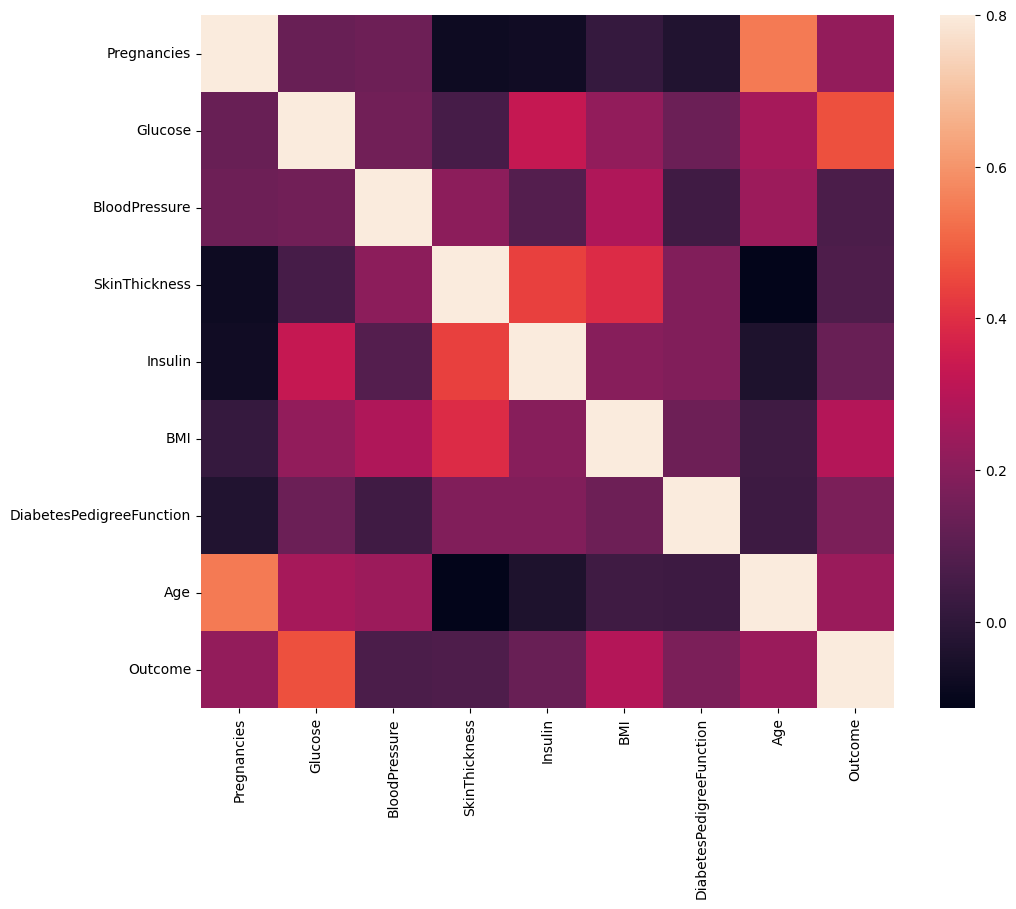

In [45]:
#Correlation Matrix
import seaborn as sns
correlation_matrix = df.corr()
fig = plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix,vmax=0.8,square = True)
plt.show()

In [46]:

columns = df.columns.tolist()
# Filter the columns to remove data we do not want
columns = [c for c in columns if c not in ["Outcome"]]
# Store the variable we are predicting
target = "Outcome"
# Define a random state
state = np.random.RandomState(42)
X = df[columns]
Y = df[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(768, 8)
(768,)


In [49]:
#Define the outlier detection methods

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X),
                                       contamination=0.5,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto',
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=0.5),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05,
                                         max_iter=-1)

}

In [50]:
#Fit the model

n_outliers = len(Diabetic)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



Isolation Forest: 290
Accuracy Score :
0.6223958333333334
Classification Report :
              precision    recall  f1-score   support

           0       0.77      0.59      0.67       500
           1       0.47      0.68      0.56       268

    accuracy                           0.62       768
   macro avg       0.62      0.63      0.61       768
weighted avg       0.67      0.62      0.63       768

Local Outlier Factor: 352
Accuracy Score :
0.5416666666666666
Classification Report :
              precision    recall  f1-score   support

           0       0.69      0.53      0.60       500
           1       0.39      0.56      0.46       268

    accuracy                           0.54       768
   macro avg       0.54      0.55      0.53       768
weighted avg       0.59      0.54      0.55       768

Support Vector Machine: 391
Accuracy Score :
0.4908854166666667
Classification Report :
              precision    recall  f1-score   support

           0       0.66      0.46  